# Casa Grande Aerial Peprocessing

In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import hipp
import history
import usgsxplore
import os

## Settings

In [ ]:
PROJECT_DIRECTORY = "/home/godinlu/Documents/history-dataset-v2/casa_grande/aerial/1978_09_06"
RAW_IMAGES = os.path.join(PROJECT_DIRECTORY, "raw_images")
PREPROCESSED_IMAGES = os.path.join(PROJECT_DIRECTORY, "preprocessed_images")

QUICKVIEW_FACTOR = 0.20

# for the downloading via USGS
username = os.getenv("USGS_USERNAME") or input("Enter your USGS username: ")
token = os.getenv("USGS_TOKEN") or input("Enter your USGS token: ")

## The Dataset

The dataset consists of **37 color aerial photographs** captured using a **Wild RC10 camera** ([calibration report](data/metadata/casa_grande_aerial/calibration_report.pdf)). The images were acquired on **September 6, 1978**, and cover the **Casa Grande Glacier** region in the United States.

They are available for download via the [USGS Earth Explorer](https://earthexplorer.usgs.gov/) platform. The images were scanned at a **high resolution of 0.025 mm/pixel**.


In [32]:
df = history.dataquery.get_casa_grande_aerial()
df.head(2)

,Entity ID,Agency,Vendor ID,Recording Technique,Project,Event,Roll,Frame,Acquisition Date,Scale,...,NW Corner Lat dec,NW Corner Long dec,NE Corner Lat dec,NE Corner Long dec,SE Corner Lat dec,SE Corner Long dec,SW Corner Lat dec,SW Corner Long dec,browse_url,geometry
0,ARBCSRD00010006,B,None,1,CSRD0,None,000001,,1978-09-06,25000,...,32.940207,-111.74625,32.940218,-111.686847,32.890127,-111.686851,32.890117,-111.746221,https://ims.cr.usgs.gov/browse/aircraft/phoeni...,"POLYGON ((-111.74622 32.89012, -111.68685 32.8..."
1,ARBCSRD00010007,B,None,1,CSRD0,None,000001,,1978-09-06,25000,...,32.91973,-111.746899,32.920262,-111.687513,32.870174,-111.686899,32.869643,-111.746252,https://ims.cr.usgs.gov/browse/aircraft/phoeni...,"POLYGON ((-111.74625 32.86964, -111.6869 32.87..."


## Step 1: Download Raw Images

To download the raw images, we will use [`usgsxplore`](https://github.com/adehecq/usgs_explorer), a Python interface to the [USGS M2M API](https://m2m.cr.usgs.gov/), which allows searching and downloading data available on the [Earth Explorer](https://earthexplorer.usgs.gov/) platform.

The full download process may take some time. Additionally, staging links provided by the [USGS M2M API](https://m2m.cr.usgs.gov/) can introduce further delays.


In [ ]:
entity_ids = df["Entity  ID"].to_list()
product_number = 1 # for the high resolution Product

# connect to the API, download raw images and logout
api = usgsxplore.API(username, token)
api.download("aerial_combin", entity_ids, product_number=product_number, output_dir=RAW_IMAGES)
api.logout()

# generate quickviews of raw images
hipp.tools.generate_quickviews(RAW_IMAGES, QUICKVIEW_FACTOR, max_workers=8)

# download also some metadata files of the dataset
history.dataquery.download_casa_grande_kh9pc_metadata(PROJECT_DIRECTORY)

Generating quickviews: 100%|██████████| 37/37 [00:10<00:00,  3.46image/s]


## Step 2 : Create a corner and midside fiducial templates

In [34]:
preproc = hipp.AerialPreprocessing(RAW_IMAGES, PREPROCESSED_IMAGES)

In [35]:
preproc.create_fiducial_template(corner=True, distance_around_fiducial=70)

In [36]:
preproc.create_fiducial_template(midside=True, distance_around_fiducial=70)

Fiducials detection: 100%|██████████| 37/37 [00:17<00:00,  2.12it/s]


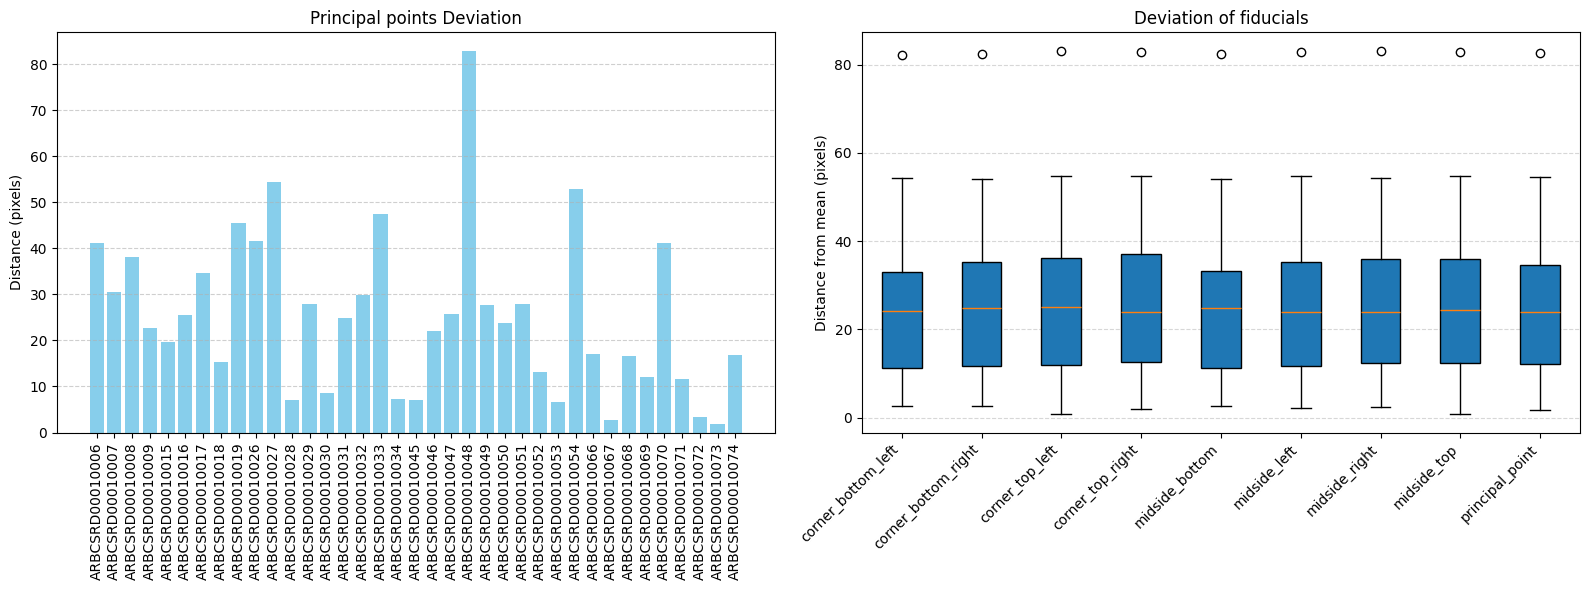

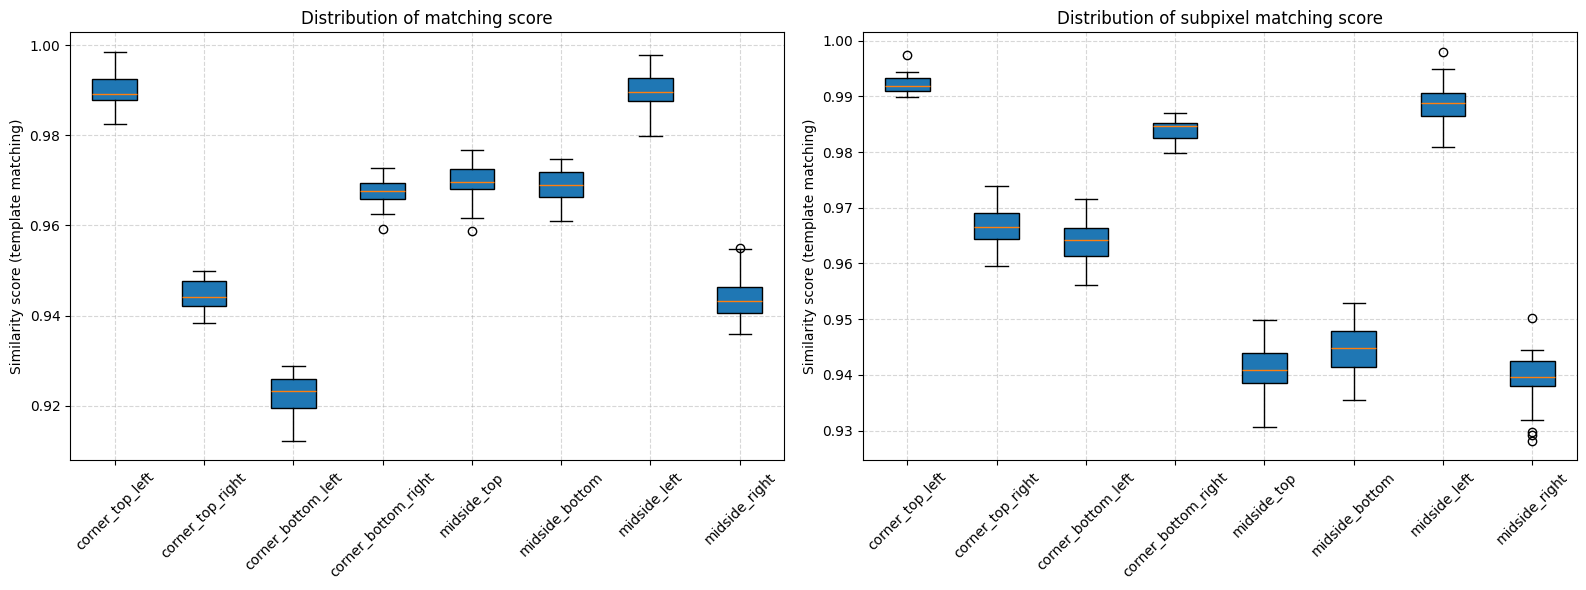

In [37]:
all_detections, all_scores, all_subpixel_scores = preproc.detect_fiducials(grid_size=7)

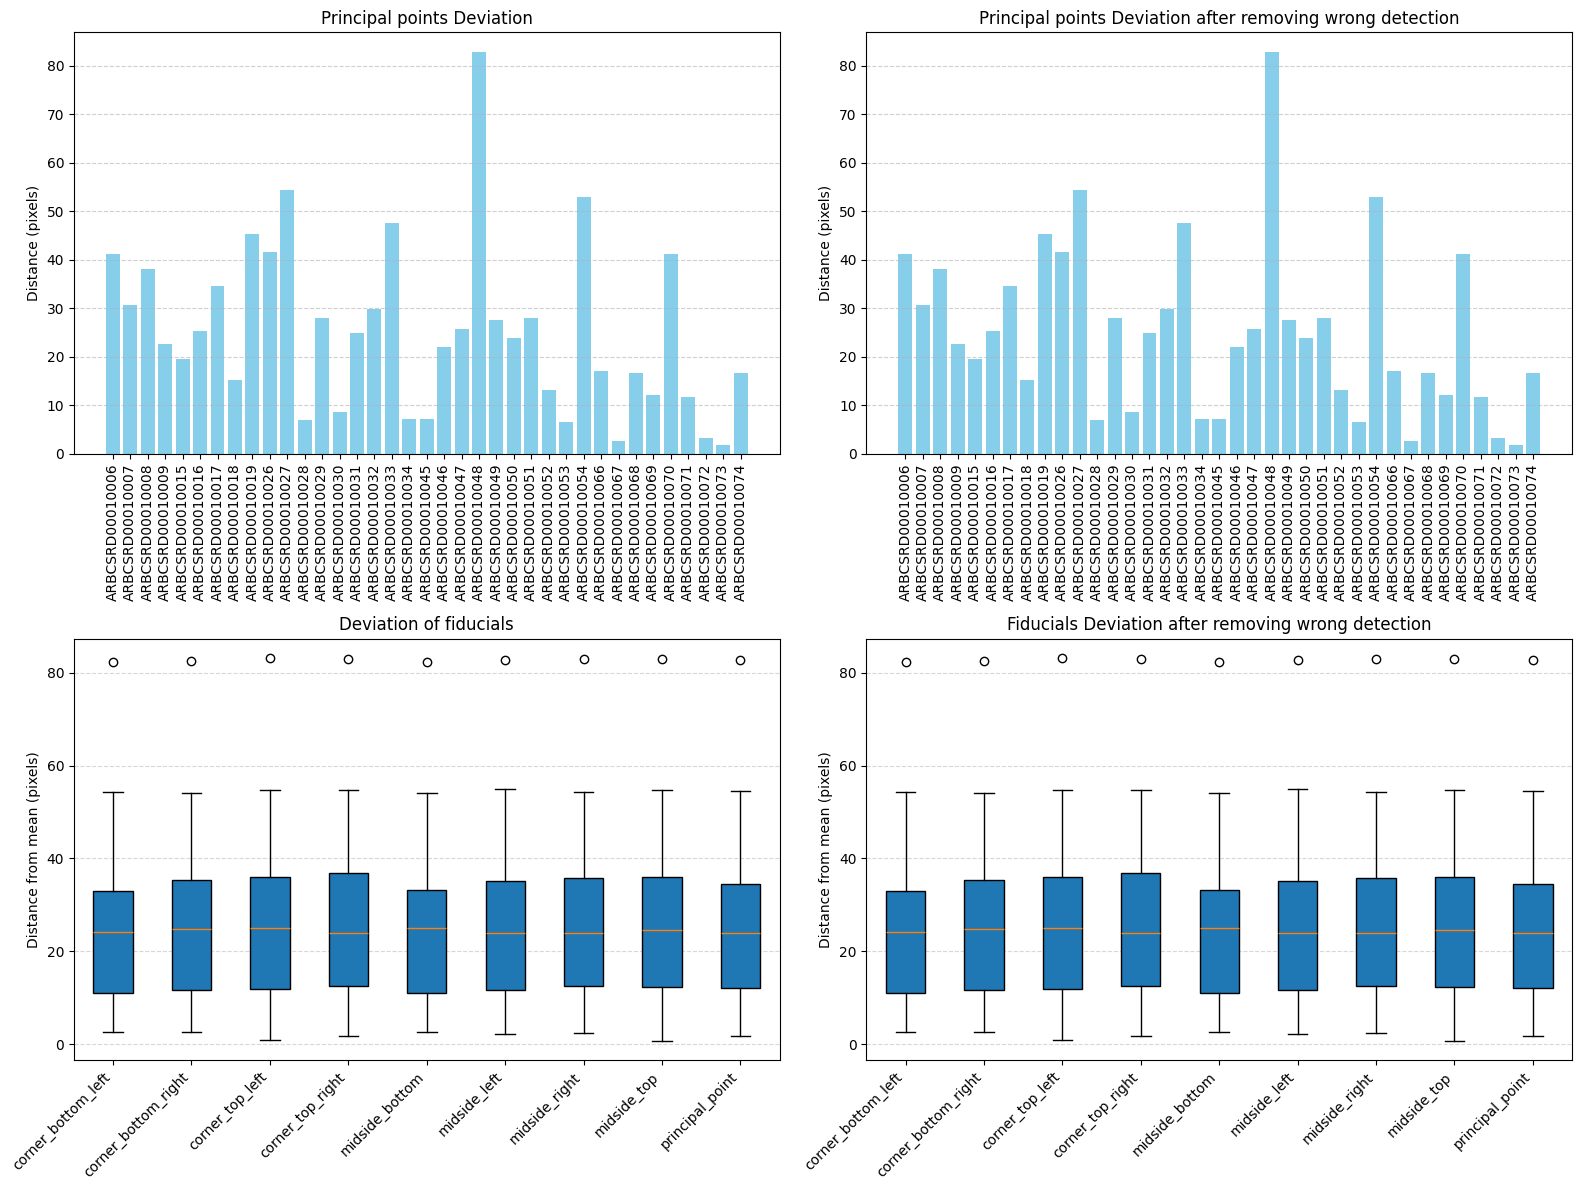

In [38]:
filtered_detections = preproc.filter_detected_fiducials(all_detections, all_scores, all_subpixel_scores, degree_threshold=0.005)
hipp.aerial.detected_fiducials_to_csv(filtered_detections, os.path.join(RAW_IMAGES, "detected_fiducial_markers.csv"))

In [39]:
true_fiducials_mm = {
    "corner_bottom_left": (-105.983, -106.005), # 1
    "corner_top_right": (105.996, 106.006), # 2
    "corner_top_left": (-105.998, 105.985), # 3
    "corner_bottom_right": (106.001, -106.005), # 4
    "midside_left": (-110.004, -0.009), # 5
    "midside_right": (110.013, 0.024), # 6
    "midside_top": (-0.003, 109.999), # 7
    "midside_bottom": (0.009, -109.992) # 8
}

In [40]:
preproc.output_directory

'/home/godinlu/Documents/history-dataset-v2/casa_grande/aerial/1978_09_06/preprocessed_images'

Generating quickviews: 100%|██████████| 37/37 [00:02<00:00, 15.45image/s]


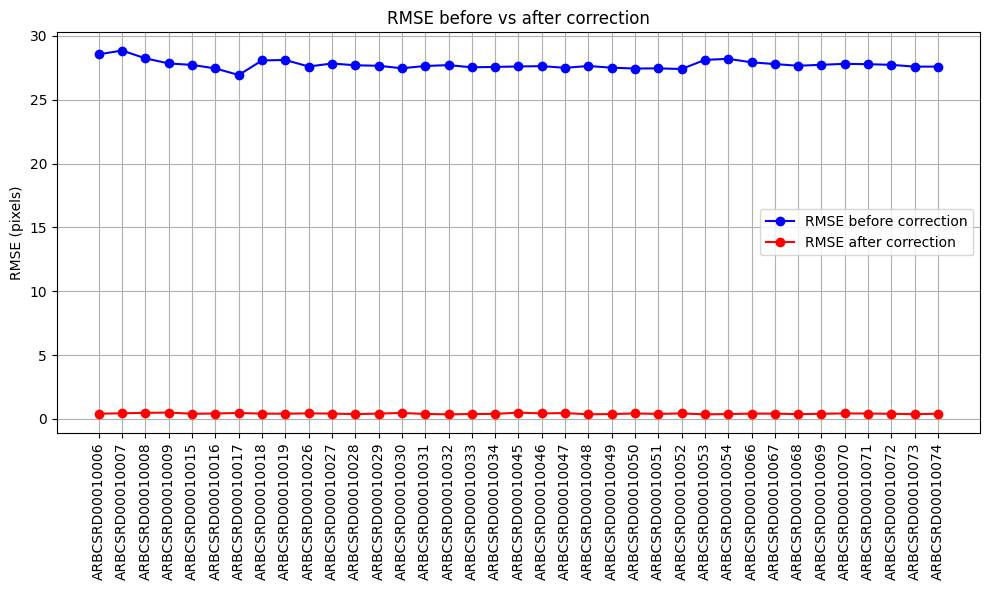

In [41]:
transformation_matrixs = preproc.images_restitution(
    filtered_detections,
    true_fiducials_mm,
    image_square_dim=8800, # this parameters can be calculated, if i want a 224 mm images then i convert in pixels with 224 / scanning_resolution_mm
    scanning_resolution_mm=0.025,
    max_workers=8,
    dry_run=False # set this option to False to transform images 
)
hipp.tools.generate_quickviews(PREPROCESSED_IMAGES, QUICKVIEW_FACTOR, max_workers=8)
transformed_detections = {k: v.transform(transformation_matrixs[k]) for k, v in filtered_detections.items()}

# we can save the transformed detections in a csv file if we want
hipp.aerial.detected_fiducials_to_csv(transformed_detections, os.path.join(PREPROCESSED_IMAGES, "detected_fiducial_markers.csv"))
